# Quantum Machine Learning with Amazon Braket: Binary Classifiers

This post details an approach taken by Aioi to build an exploratory
quantum machine learning application using Amazon Braket. Quantum
machine learning has been defined as "a research area that explores the
interplay of ideas from quantum computing and machine learning." Specifically, we explore how to use quantum computers to build a proof-of-principle classifier for risk assessment in a hypothetical car insurance use case.  We use a hybrid quantum-classical approach and train a so-called quantum neural network to perform binary classification.

## Background

  This demonstration is a result of collaboration with Aioi USA -
subsidiary of Aioi Nissay Dowa Insurance which is a member of MS&AD
Insurance Group Holdings - a major worldwide insurance organization
with close ties to the Toyota group, offering Toyota Insurance in 37
countries. Aioi USA is a full-service "insurtech" insurance agency
that develops data science-based products and services for the
transportation industry. Aioi was one of the first insurance companies
to work with Amazon Braket.

Aioi analyzes telematics data from self-driving vehicles to predict
driving risks. The vehicles are equipped with a multitude of sensors and
the goal is to use the sensor data to assign each vehicle a binary score
(safe or fail) that indicates the health of the vehicle. The problem can
be formalized computationally as a binary classification task in which
the driving risk score is a binary label to vehicle's sensor data.

To learn label assignments for each data point, classical machine learning
techniques such as e.g., linear regression (LR) or deep learning (DL)
can be applied. LR is a popular approach when the data-label mapping
is described by a linear function. For large and complex data structures, DL offers a way to capture
nonlinear behavior in data-label mapping.

So, we have powerful classical methods to perform classification tasks; how can quantum computers help here?  The short answer is, we don't quite know yet. There are results ([arXiv:1204.5242](https://arxiv.org/abs/1204.5242), [arXiv:1601.07823](https://arxiv.org/abs/1601.07823) ) indicating that quantum LR algorithms applied to quantum data under specific assumptions can be exponentially faster than their classical counterparts operating on classical data. The flip side is that these quantum algorithms output a solution in the form of a quantum state which may not be immediately useful for further processing on a classical computer. On the DL front, quantum neural networks (QNNs) emerged as a potential replacement for classical neural nets ([arXiv:quant-ph/0201144](https://arxiv.org/abs/quant-ph/0201144)) . QNN designs to perform binary classification tasks were proposed recently (see e.g., [arXiv:1802.06002](https://arxiv.org/abs/1802.06002)) as well. An advantage of QNNs is that they can directly output a classical label value, though one still has to input data in the form of a quantum state. Whether or not QNNs have practical computational advantage over classical neural nets in DL task is very much an area of active research and the jury is not out yet on QNNs. This motivated us to explore how QNNs can be utilized for the driving risk
assignment in the case of binary sensor data with an eye towards near-term hardware implementation that constraints QNN's circuit depth due to decoherence. 

        
In this post we build quantum machine learning applications using [Amazon Braket](https://aws.amazon.com/braket/). To run the example applications developed here, you need access to the [Amazon Braket SDK](https://github.com/aws/amazon-braket-sdk-python). You can either install the Braket SDK locally from the [Amazon Braket GitHub repo](https://github.com/aws/amazon-braket-sdk-python) or, alternatively, create a managed notebook in the [Amazon Braket console](https://aws.amazon.com/console/). (Please note that you need an AWS account, if you would like to run this demo on one of the quantum hardware backends offered by Amazon Braket.)

## Problem Setting

   Binary classification is an example of supervised machine learning. It
requires a training data set to build a model that can be used to predict
labels (driving risk scores). We assume that we are given a training set
$T$ that consists of $M$ data-label pairs ${\bf x}, {\bf y}$
$(T=\{{\bf x}_i, {\bf y}_i\}$,$i=1,M)$. Here, ${\bf x}_i$ represents vehicle sensor data as a $N$-bit string
${\bf x}_i=\{x_{i0},\cdots,x_{iN-1}\}$ ($x_{ij}=\{0,1\}$). A label
${\bf y}_i=\{0,1\}$ represents the driving risk score associated with ${\bf x}_i$.

Before we proceed with a quantum solution, it is instructive to recall
the main steps of constructing a classical neural net (NN) based
solution. A classical NN takes data ${\bf x}$ and a set of
parameters $\vec{\theta}$ (so-called weights) as an input and transforms it into an output
label ${\bf z}$ such that $\hat{{\bf y} }= f({\bf x},\vec{\theta})$ where
$f$ is determined by NN. The goal is then
to use a training set to train the NN, i.e. to determine the values of
$\vec{\theta}$ for which the discrepancy between the output labels and
the training set labels is minimized. You achieve this by minimizing a
suitably chosen loss function $L(\hat{{\bf y}},{\bf y})$ over the NN
parameters $\vec{\theta}$ using e.g., a gradient-based optimizer.

To construct a quantum binary classifier we follow a similar procedure
with a couple of modifications 

- We map our classical $N$-bit data $\{{\bf x}_i\}$ onto $N$-qubit quantum states $\{|\psi_i\rangle \}$. For example, a classical bit string $\{{\bf x}_i\}=0010$ maps onto $|\psi_i\rangle = |0010\rangle$ 

- Instead of a classical NN we construct a QNN - a $N+1$-qubit circuit $\mathcal{C}(\{\vec{\theta}\})$ (a sequence of elementary single- and two-qubit gates) that transforms the input states $\{|\psi_i\rangle|0\rangle \}$ into output states $\{|\phi_i \rangle \}$ $|\phi_i\rangle = \mathcal{C}|\psi_i\rangle $. The QNN circuit $\mathcal{C}(\{\vec{\theta}\})$ depends on classical parameters $\{\vec{\theta}\}$ that can be adjusted to change the output $\{|\phi_i\rangle \}$

- We use the $N+1$-th qubit to read out labels after the QNN acted on the input state.  Every time we run the QNN with the same input state and parameters $\{\vec{\theta}\}$, we measure in what quantum state the $N+1$-th qubit ends up ($|0\rangle$ or $|1\rangle$). We denote the frequency of observing the state $|0\rangle$ ($|1\rangle$ ) as $p_0$ ($p_1$). We define the observed label $\hat{{\bf y}}$ as $\hat{{\bf y}} = \frac{1 - (p_0-p_1)}{2}$. (Note: in the language of quantum computing the difference $p_0-p_1$ equals the expected value of the Pauli $\hat{Z}$ operator measured on the $N+1$-th qubit.) By definition, $p_0-p_1$ is a function of the QNN parameters $\{\vec{\theta}\}$ in the range $ [-1,1] $ and, thus, $\hat{{\bf y}}$ has the range $ [0,1] $ .

In the training of the QNN circuit $\mathcal{C}$ our goal is to find a set of parameters $\{\vec{\theta}_o\}$ such that for each data point in the training set $T$ the label value ${\bf y}_i$ is close
to $\hat{{\bf y}}_i$.
To achieve this, we minimize the log loss function $L(\{\vec{\theta}\})$  defined as,

$L(\{\vec{\theta}\})=-(\sum\limits_{i=1}^{M}{\bf y}_i\log(\hat{{\bf y}}_i)+(1-{\bf y}_i)\log(1-\hat{{\bf y}}_i))$.

We use the Amazon Braket local simulator to evaluate $L(\{\vec{\theta}\})$ and a classical optimizer from $\verb+scipy.optimize+$ to minimize it.

## Mapping classical data onto quantum states. 

The first step in the implementation of a quantum binary classifier is to specify a quantum circuit that maps classical data onto quantum states. We map classical bit values "0" and "1" onto quantum states
$|0\rangle$ and $|1\rangle$, respectively. By convention, the
initial state of a qubit is always assumed to be $|0\rangle$. If the
input quantum state is $|1\rangle$ then we obtain it from
$|0\rangle$ by applying a qubit flip gate $X$ i.e.
$|1\rangle = X|0\rangle$. Similarly, a quantum circuit to prepare an
input state, corresponding to classical data, consists of $X$
gates acting on qubits that are in state $|1\rangle$. For example, a
quantum circuit to prepare $|\psi_i\rangle =|101\rangle$ will consist
of two $X$ gate acting on qubits 0 and 2. Below we provide code that
generates a quantum circuit for preparing an arbitrary computational basis state
$|\psi_i\rangle$ using Amazon Braket.

In [ ]:
# Import Braket libraries
from braket.circuits import Circuit
from braket.aws import AwsDevice

# A function that converts a bit string bitStr into a quantum circuit
def bit_string_to_circuit(bitStr):  
    circuit = Circuit()
    for ind in range(len(bitStr)):
        if bitStr[ind]=='1':
            circuit.x(ind)
            
    return circuit
    
# provide a feature string to test the function above
feature = '00101010'

# print quantum circuit that prepares corresponding quantum state 
print(bit_string_to_circuit(feature))

## Designing Quantum Neural Networks and Training

Now that we know how to prepare input quantum states that correspond to classical data, the next step is to define and constuct a QNN circuit $\mathcal{C}(\{\vec{\theta}\})$ that we will train to
perform binary classification. We use the QNN design layout depicted in
the figure below. It is has $2N+1$ classical parameters defining:
$N$ two-qubit gates
$XX(\theta_k) = e^{-i\frac{\theta_k}{2} \hat{X}_j\hat{X}_{N+1}}$, $N$
single-qubit gates $R_{y}(\theta_m) = e^{-i\frac{\theta_m}{2}\hat{Y}_j}$, and one single-qubit gate $R_{x}(\theta) = e^{-i\frac{\theta}{2}\hat{X}_N}$ acting on the $N+1$-th qubit..

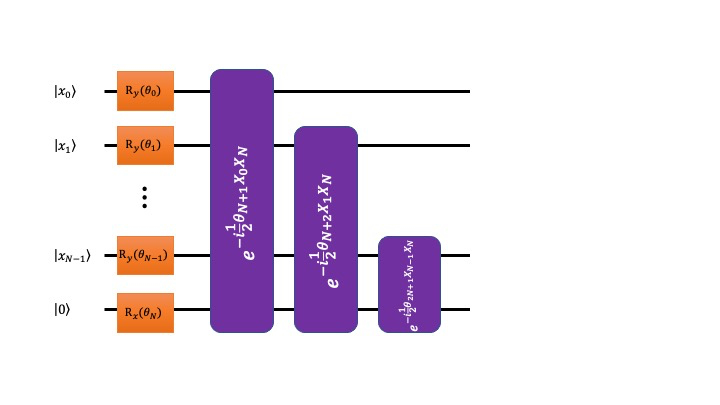

The code below implements this QNN, applies it to an arbitrary input state defined by a classical bit string, and measures the values of the label qubit using Amazon Braket.

In [ ]:
# import standard numpy libraries and optimizers
import numpy as np
from scipy.optimize import minimize

# Braket imports
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.aws import AwsDevice, AwsQuantumTask
from braket.devices import LocalSimulator

# set Braket backend to local simulator (can be changed to other backends)
device = LocalSimulator() 

# Quantum Neural Net from the QNN figure implemented in Braket
# Inputs: bitStr - data bit string (e.g. '01010101')
#         pars - array of parameters theta (see the QNN figure for more details) 

def QNN(bitStr,pars):
    ## size of the quantum neural net circuit
    nQbts = len(bitStr) + 1 # extra qubit is allocated for the label 
    
    ## initialize the circuit
    qnn = Circuit()
    
    ## add single-qubit X rotation to the label qubit, 
    ## initialize the input state to the one specified by bitStr
    ## add single-qubit Y rotations to data qubits, 
    ## add XX gate between qubit i and the label qubit, 
    qnn.rx(nQbts-1, pars[0])
    for ind in range(nQbts-1):
        angles = pars[2*ind + 1:2*ind+1+2]
        if bitStr[ind] == '1': # by default Braket sets input states to '0', 
                               # qnn.x(ind) flips qubit number ind to state |1\ 
            qnn.x(ind)
        qnn.ry(ind, angles[0]).xx(ind, nQbts-1, angles[1])
    
    ## add Z observable to the label qubit
    observZ = Observable.Z()
    qnn.expectation(observZ, target=[nQbts-1]) 
    
    return qnn

With the QNN defined, we need to code up the loss function $L(\{\vec{\theta}\})$ that we minimize in order to train
the QNN to perform binary classification. Below is the code that computes $L(\{\vec{\theta}\})$ using the local simulator in Amazon Braket.

In [ ]:
## Function that computes the label of a given feature bit sting bitStr

def parity(bitStr):
    return bitStr.count('1') % 2

## Log loss function L(theta,phi) for a given training set trainSet
## inputs: trainSet - array of feature bit strings e.g. ['0101','1110','0000'] 
##         pars - quantum neural net parameters theta (See the QNN figure)
##         device -  Braket backend that will compute the log loss
def loss(trainSet, pars, device):
    loss = 0.0
    for ind in range(np.size(trainSet)):  
        ## run QNN on Braket device
        task = device.run(QNN(trainSet[ind], pars), shots=0) 
        ## retrieve the run results <Z>
        result = task.result()
          
        if parity(trainSet[ind])==0:
            loss += -np.log2(1.0-0.5*(1.0-result.values[0]))
        else:
            loss += -np.log2(0.5*(1.0-result.values[0]))
    print ("Current value of the loss function: ", loss)
    return loss

Putting it all together we are now ready to train our QNN circuit to reproduce binary classification of a training set $T$. For the example below, we assume that labels ${\bf y}_i$ are generated by a Boolean function $\hat{f}({\bf x}_i) = (\sum\limits_{j=0}^{N-1}x_{ij})\ {\rm mod}\ 2$. To emulate data in the training set $T$, we generated $11$ random $10$-bit strings (data) and assign them labels according to $\hat{f}$. 

In [ ]:
## Training the QNN using gradient-based optimizer
nBits = 10 # number of bits per feature

## Random training set consisting of 11 10-bit features
## Please explore other training sets
trainSet = ['1101011010',
            '1000110011',
            '0101001001',
            '0010000110',
            '0101111010',
            '0000100010',
            '1001010000',
            '1100110001',
            '1000010001',
            '0000111101',
            '0000000001']

## Initial assignment of QNN parameters theta and phi (random angles in [-pi,pi]) 
pars0 = 2 * np.pi * np.random.rand(2*nBits+1) - np.pi

## Run minimization
res = minimize(lambda pars: loss(trainSet, pars, device), pars0, method='BFGS', options={'disp':True})

Run the code and wait for the optimizer to converge. It outputs a message that looks like this when the optimizer finishes.

In [ ]:
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 1430
         Gradient evaluations: 65

We note that our QNN circuit is designed to compute the parity of input data exactly for an appropriate choice of the parameters $\{\vec{\theta}\}$. Thus, the global minimum of the loss function using this QNN is zero. This is generally not the case in DL applications, however. Note also that $L(\{\vec{\theta}\})$ is not convex
with respect to the parameters $\{\vec{\theta}\}$. This means that if the final value of the loss function value is not zero, the optimizer got stuck in a local minimum. Do not panic. Try running the optimizer with a
different set of initial parameters \verb+pars0+. You can also explore various minimization algorithms by
specifying $\verb+method=' '+$ in the minimize function.

Calling $\verb+res.x+$ outputs the optimal values of the parameters $\{\vec{\theta}\}$
and you can use them to run the "optimal" QNN and perform binary classification on the data that is not a part of the training set. Try that and compute the mean square error of the classifier.

For our 10-bit data example there are $2^{10}=1024$ possible
10-bit strings, we chose a training set that has only 11 data points. Yet it is
sufficiently large to train the QNN to act as a perfect
binary classifier for all 1024 possible features. Can you demonstrate
that?

In [ ]:
## Print the predicted label values for all N-bit data points using the optimal QNN parameters res.x
for ind in range(2**nBits):
    data = format(ind, '0'+str(nBits)+'b')
    task = device.run(QNN(data, res.x), shots=100)
    result = task.result()
    if (data in trainSet):
        inSet = 'in the training set'
    else:
        inSet = 'NOT in the training set'
    print('Feature:', data, '| QNN predicted parity: ', 0.5*(1-result.values[0]), ' | ', inSet) 
    print('---------------------------------------------------')

 As an exercise, use the optimal QNN parameters in $\verb+res.x+$ and apply the
resulting QNN to all 10-bit strings that are not in the training set.
Record the mean square error between the predicted and computed label
values.

### Conclusion
This post explored the use case of binary classification to analyze
binary (telematic) data by combining QNNs with Amazon Braket. The QNN binary classifier designed in this post
requires the number of two-qubit gates that scales linearly with the
feature size. This is advantageous for Noisy Intermediate Scale Quantum
(NISQ) devices that are limited in the circuit depth due to noise. A
future area of investigation for the team is to apply more complex
feature sets, and constructing QNNs to classify them. You can download and play with the code from this post here.